### Libraries used

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random as rd
from scipy.integrate import quad
from matplotlib import colors
from IPython import display
import time

### Functions and constants

In [4]:
global vacancy_value, agent_value, m
vacancy_value = 0
agent_value = 1
m = 0.5

In [5]:
def utility_function_per_block(pho):
    if(pho <= 0.5):
        res = 2*pho
    else:
        res = 2*(m-1)*pho + (2 - m)
    return res

In [6]:
def plot_grid(agents, n, alpha):
    # creates a discrete colormap
    vacancy = np.array([147.0/255, 148.0/255, 150.0/255])     # grey
    agent =  np.array([255.0/255, (alpha) * 255.0/255, 0.0/255])       # red -> yellow
    cmap = colors.ListedColormap([vacancy, agent])
    # determines the limits of each color:
    bounds = [vacancy_value, agent_value, agent_value + 1]            
    norm = colors.BoundaryNorm(bounds, cmap.N)

    size = 8
    fig, ax = plt.subplots(figsize=(size,size))
    ax.imshow(agents, cmap=cmap, norm=norm)

    # draws gridlines
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
    ax.set_xticks(np.arange(-0.5, agents.shape[1], n));
    ax.set_yticks(np.arange(-0.5, agents.shape[0], n));

    plt.show()

In [7]:
def create_city_Q(n, Q, agent_density_1, agent_density_2):
    vacancy_array = np.array([[-1,-1,-1]])
    agent_array   = np.array([[-1,-1,-1]])
    density_array = np.full(Q,0.0)
    city_side = n*Q
    
    # creates a city without borders, that will be a toroidal grid
    city = np.full((n,city_side), vacancy_value)
    
    for code in range(Q):
        if code == 0:
            agent_density = agent_density_1
        elif code == 1:
            agent_density = agent_density_2
            
        block_x = int((code%Q) * n)
        block_y = int(np.floor(code/Q) * n)
        
        agents_in_block = 0.0
        
        count = 0
        for di in range(0,n):
            for dj in range(0,n):
                count += 1
                i = block_y + di
                j = block_x + dj
                if count/(n*n) <= agent_density:
                    city[i,j] = agent_value
                    agents_in_block += 1.0
                    agent_array = np.append(agent_array, [[code, i, j]], axis=0)
                else:
                    vacancy_array = np.append(vacancy_array, [[code, i, j]], axis=0)
                    
        count = 0
        
        block_density = agents_in_block/(n*n)
        density_array[code] = block_density 

    vacancy_array = np.delete(vacancy_array, 0,0)
    agent_array = np.delete(agent_array, 0,0)
    
    return city, vacancy_array, agent_array, density_array

In [8]:
def detect_city_utility(n, density_array, agent_array): 
    #check city utility
    city_utility = 0.0

    for pho in density_array:
        city_utility += utility_function_per_block(pho)*pho*n*n
    
    return city_utility

In [9]:
def simulation_step(n, T, alpha, city, vacancy_array, agent_array, density_array):
    if len(agent_array) == 0 or len(vacancy_array) == 0:
        return city, vacancy_array, agent_array, density_array
    #we choose an agent and a vancant site in another block, it moves if its utility function increases.
    rndV = np.random.randint(0, len(vacancy_array))
    rndA = np.random.randint(0, len(agent_array))
    codeV = vacancy_array[rndV,0] 
    codeA = agent_array[rndA,0]
    if codeV == codeA:
        return city, vacancy_array, agent_array, density_array
    phoV = density_array[codeV]
    phoA = density_array[codeA]
    
    iV, jV = vacancy_array[rndV,1:3]
    iA, jA = agent_array[rndA,1:3]
    
    #computing delta agent utility
    agent_utility = utility_function_per_block(phoA)
    new_agent_utility = utility_function_per_block(phoV + 1/(n*n))
    delta_agent_utility = new_agent_utility - agent_utility
    
    #computing delta city utility
    city_utility = detect_city_utility(n, density_array, agent_array)
    density_array[codeV] += 1/(n*n)
    density_array[codeA] -= 1/(n*n)
    new_city_utility = detect_city_utility(n, density_array, agent_array)
    density_array[codeV] = phoV
    density_array[codeA] = phoA
    delta_city_utility = new_city_utility - city_utility
    
    #computing gain
    gain = delta_agent_utility + alpha * (delta_city_utility - delta_agent_utility)
    
    #computing movement probability
    if (T != 0):
        prob = 1 / (1 + np.exp(-gain/T))
    else:
        if gain > 0:
            prob = 1
        elif gain < 0:
            prob = 0
        else:
            prob = 1/2
    
    rnd = np.random.random()
    
    if(rnd <= prob):
        #update system
        
        #update vacancy and agent arrays
        vacancy_array[rndV] = [codeA,iA,jA]
        agent_array[rndA] = [codeV,iV,jV]

        #update city grid
        city[iA,jA] = vacancy_value
        city[iV,jV] = agent_value
        
        #update density array
        density_array[codeV] += 1/(n*n)
        density_array[codeA] -= 1/(n*n)
    
    return city, vacancy_array, agent_array, density_array

#### MODEL TESTING

##### Manually choosen density system

Enter the initial number of agents in block 1. It has to be between 20.0 and 100, closed intervalls. 85


Initial conditions:
Block 1: 85 (0.85)
Block 2: 35.0 (0.35)
Final results:
Block 1: 60 (0.6)
Block 2: 60 (0.6)


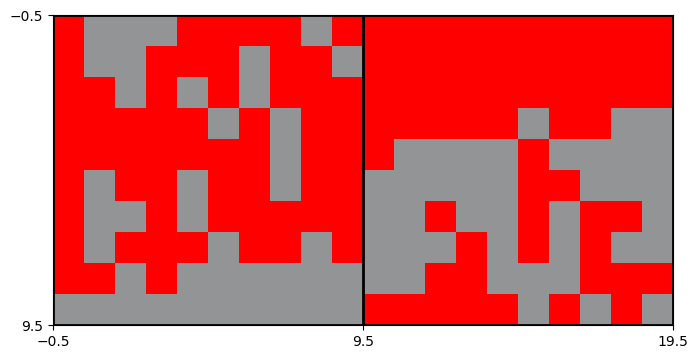

In [29]:
n = 10
H = n*n
Q = 2
T = 0
alpha = 0

N = 2*H*0.6
total_density = N/(2*H)

if N/(2*H) >= 0.5:
        i_min = N - H
        i_max = H
    
# if total density is less then 0.5
else:
    i_min = 0
    i_max = N

initial_number_of_agents = int(input(f"Enter the initial number of agents in block 1. It has to be between {i_min} and {i_max}, closed intervalls."))
agent_density_1 = initial_number_of_agents/H
agent_density_2 = (N - initial_number_of_agents)/H

print("Initial conditions:")
print(f"Block 1: {initial_number_of_agents} ({agent_density_1})")
print(f"Block 2: {N - initial_number_of_agents} ({agent_density_2})")

simulations = 1

for _ in range(simulations):
    city, vacancy_array, agent_array, density_array = create_city_Q(n, Q, agent_density_1, agent_density_2)

    steps = 10000

    for a in range(steps):
        city, vacancy_array, agent_array, density_array = simulation_step(n, T, alpha, city, vacancy_array, agent_array, density_array)

print("Final results:")
print(f"Block 1: {round(density_array[0]*H)} ({round(density_array[0],3)})")
print(f"Block 2: {round(density_array[1]*H)} ({round(density_array[1],3)})")
plot_grid(city, n, alpha)

##### Multiple values for alpha and initial density

In [139]:
n = 10
H = n*n
Q = 2
T = 0

N = 80
total_density = N/(2*H)

if N/(2*H) >= 0.5:
    i_min = N - H
    i_max = H
    
# if total density is less then 0.5
else:
    i_min = 0
    i_max = N

alphas = np.linspace(0,1,11, endpoint=True)
initials = np.linspace(i_min, i_max, 11, endpoint=True, dtype=int)

results = dict()

for alpha in alphas:
    print(alpha)
    for initial in initials:

        agent_density_1 = initial/H
        agent_density_2 = (N - initial)/H

        simulations = 10
        earlier = False
        res = "homogeneous"
        counter = 0
        
        for _ in range(simulations):
            counter = 0
            if earlier:
                break
            city, vacancy_array, agent_array, density_array = create_city_Q(n, Q, agent_density_1, agent_density_2)
        
            steps = 10000
        
            for a in range(steps):
                city, vacancy_array, agent_array, density_array = simulation_step(n, T, alpha, city, vacancy_array, agent_array, density_array)
                if any(density < 2/H for density in density_array):
                    counter += 1
                    if counter > 50:
                        res = "segregated"
                        earlier = True
                        break
            
        results[(alpha,initial)] = res

0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
1.0


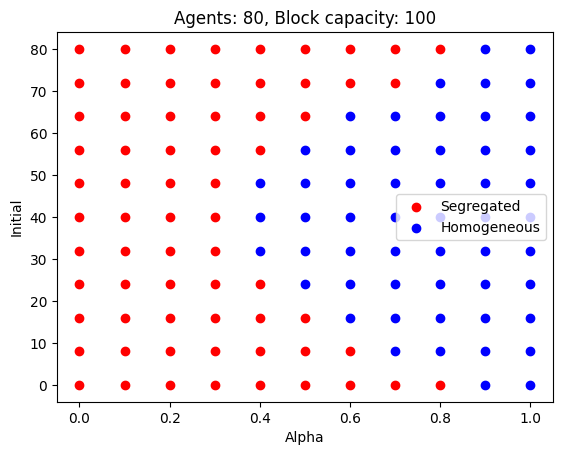

In [140]:
# Separe os dados por categoria
segregated = {key: value for key, value in results.items() if value == 'segregated'}
homogeneous = {key: value for key, value in results.items() if value == 'homogeneous'}

# Extraia as coordenadas para os pontos e suas cores
alpha_segregated, initial_segregated = zip(*segregated.keys())
alpha_homogeneous, initial_homogeneous = zip(*homogeneous.keys())

# Crie o plot
plt.scatter(alpha_segregated, initial_segregated, color='red', label='Segregated')
plt.scatter(alpha_homogeneous, initial_homogeneous, color='blue', label='Homogeneous')

# Adicione legendas e rótulos
plt.legend()
plt.xlabel('Alpha')
plt.ylabel('Initial')
plt.title(f'Agents: {N}, Block capacity: {H}')

# Mostre o gráfico
plt.show()

##### Segregation (red) and Homogeneity (blue) of systems with T=0, alpha = 0 and 0 < m < 1

In [8]:
n = 10
Q = 2
T = 0
alpha = 0

densities_len = 9
densities = np.linspace(0.1,0.9,densities_len,endpoint=True)

results = np.zeros((densities_len,densities_len, 2))

steps = 5000
simulations = 1

for i in range(densities_len):
    agent_density_1 = densities[i]
    for j in range(densities_len):
        agent_density_2 = densities[j]
        
        for _ in range(simulations):
            city, vacancy_array, agent_array, density_array = create_city_Q(n, Q, agent_density_1, agent_density_2)

            for _ in range(steps):
                city, vacancy_array, agent_array, density_array = simulation_step(n, T, alpha, city, vacancy_array, agent_array, density_array)
                
            results[i,j] = density_array

###### Red := segregation; Blue := homogeneity (little squares in the biggest ones indicates teoretical results)

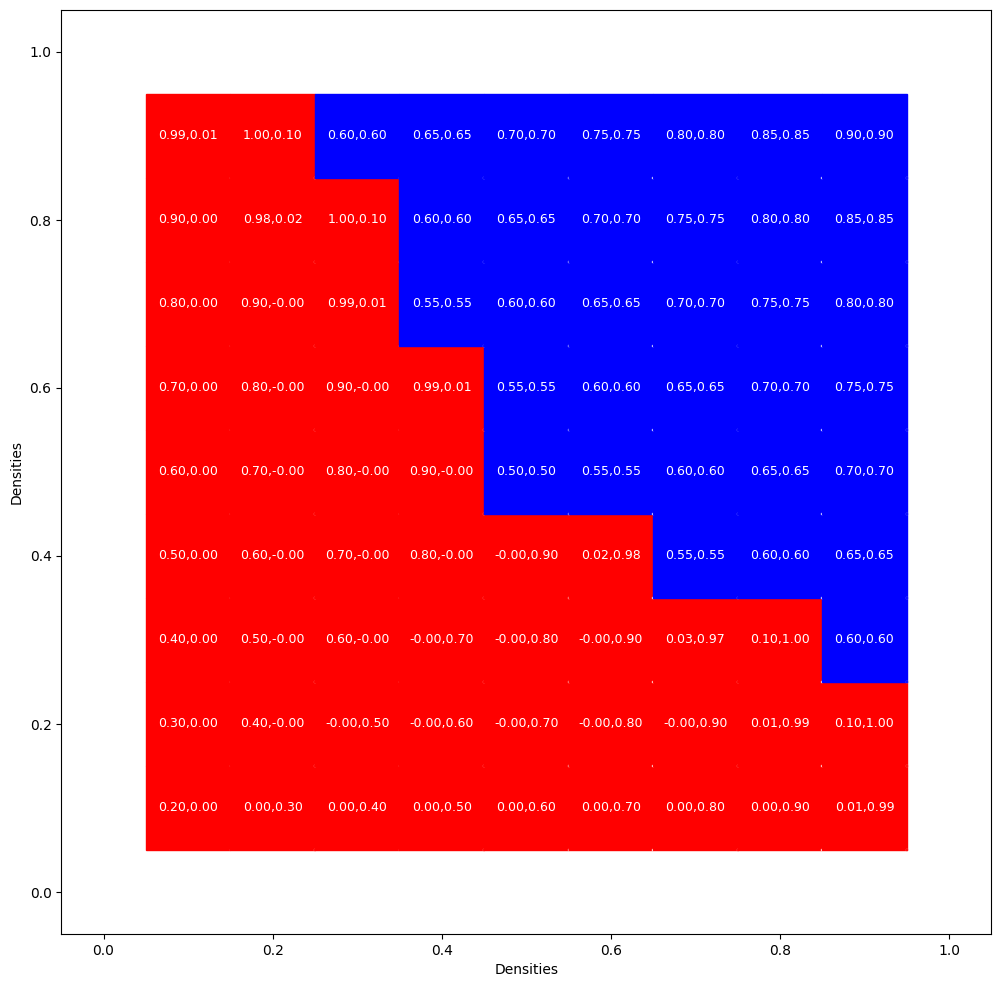

In [9]:
x = np.array(densities)
y = np.array(densities)

# create grid in coordinates x, y
X, Y = np.meshgrid(x, y)

# create figure
fig, ax = plt.subplots(figsize=(12, 12))

for i in range(len(densities)):
    for j in range(len(densities)):
        text = "%.2f,%.2f" % (results[i,j,0] , results[i,j,1])
        if (np.min(results[i,j])/np.max(results[i,j])) <= 0.9:
            color = "red"
        else:
            color = "blue"
            
        square_size = 0.1
        cell = plt.Rectangle((X[i][j] - 0.05, Y[i][j] - 0.05), square_size, square_size, fill=True, color= color)
        ax.add_patch(cell)
        
        detail_square_size = 0.001
        cell_small = plt.Rectangle((X[i][j] + square_size/2 - detail_square_size, Y[i][j] - square_size/2), detail_square_size, detail_square_size, fill=True, color= 'white')
        ax.add_patch(cell_small)
        
        # teoretical result
        small_density = min(densities[i],densities[j])
        big_density = max(densities[i],densities[j])
        if(small_density == big_density):
            if(small_density < 0.5):
                color2 = "red"
            else:
                color2 = "blue"
        else:
            if(utility_function_per_block(big_density) < utility_function_per_block(small_density)):
                color2 = "blue"
            else:
                color2 = "red"
            
        small_square_size = 0.0005
        cell_small = plt.Rectangle((X[i][j] + square_size/2 - small_square_size - detail_square_size/8, Y[i][j] - square_size/2 + detail_square_size/10), small_square_size, small_square_size, fill=True, color= color2)
        ax.add_patch(cell_small)
        
        
        ax.text(X[i][j], Y[i][j], text, va='center', ha='center', fontsize=9, color='white')

# Labels
ax.set_xlabel('Densities')
ax.set_ylabel('Densities')

# Graph limits
ax.set_xlim(x[0] - 0.15, np.max(x) + 0.15)
ax.set_ylim(y[0] - 0.15, np.max(y) + 0.15)

plt.show()

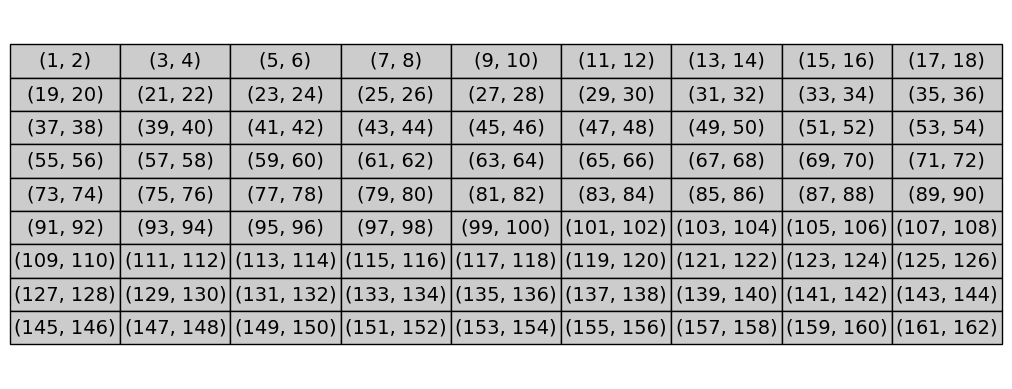

In [51]:
import matplotlib.pyplot as plt

# Matriz 9x9 de elementos 2D de exemplo
results = [[(1, 2), (3, 4), (5, 6), (7, 8), (9, 10), (11, 12), (13, 14), (15, 16), (17, 18)],
           [(19, 20), (21, 22), (23, 24), (25, 26), (27, 28), (29, 30), (31, 32), (33, 34), (35, 36)],
           [(37, 38), (39, 40), (41, 42), (43, 44), (45, 46), (47, 48), (49, 50), (51, 52), (53, 54)],
           [(55, 56), (57, 58), (59, 60), (61, 62), (63, 64), (65, 66), (67, 68), (69, 70), (71, 72)],
           [(73, 74), (75, 76), (77, 78), (79, 80), (81, 82), (83, 84), (85, 86), (87, 88), (89, 90)],
           [(91, 92), (93, 94), (95, 96), (97, 98), (99, 100), (101, 102), (103, 104), (105, 106), (107, 108)],
           [(109, 110), (111, 112), (113, 114), (115, 116), (117, 118), (119, 120), (121, 122), (123, 124), (125, 126)],
           [(127, 128), (129, 130), (131, 132), (133, 134), (135, 136), (137, 138), (139, 140), (141, 142), (143, 144)],
           [(145, 146), (147, 148), (149, 150), (151, 152), (153, 154), (155, 156), (157, 158), (159, 160), (161, 162)]]

# Crie a figura e o eixo
fig, ax = plt.subplots()

# Ajuste o tamanho das células e o espaçamento entre elas
table = ax.table(cellText=results, loc='center', cellLoc='center', cellColours=[[(0.8, 0.8, 0.8)] * 9] * 9)
table.auto_set_font_size(False)
table.scale(2, 2)  # Ajuste a escala para tornar as células mais altas

# Defina o tamanho da fonte
for key, cell in table._cells.items():
    cell.set_text_props(fontsize=14)

# Remova as linhas e colunas padrão da tabela
ax.axis('off')

# Mostre o gráfico
plt.show()


##### Segregation (red) and Homogeneity (blue) for systems with T=0, alpha = 1 and 0 < m < 1 

In [201]:
n = 10
Q = 2
T = 0
alpha = 1

densities_len = 9
densities = np.linspace(0.1,0.9,densities_len,endpoint=True)

results = np.zeros((densities_len,densities_len, 2))

steps = 5000
simulations = 1

for i in range(densities_len):
    agent_density_1 = densities[i]
    for j in range(densities_len):
        agent_density_2 = densities[j]
        
        for _ in range(simulations):
            city, vacancy_array, agent_array, density_array = create_city_Q(n, Q, agent_density_1, agent_density_2)

            for _ in range(steps):
                city, vacancy_array, agent_array, density_array = simulation_step(n, T, alpha, city, vacancy_array, agent_array, density_array)
                
            results[i,j] = density_array

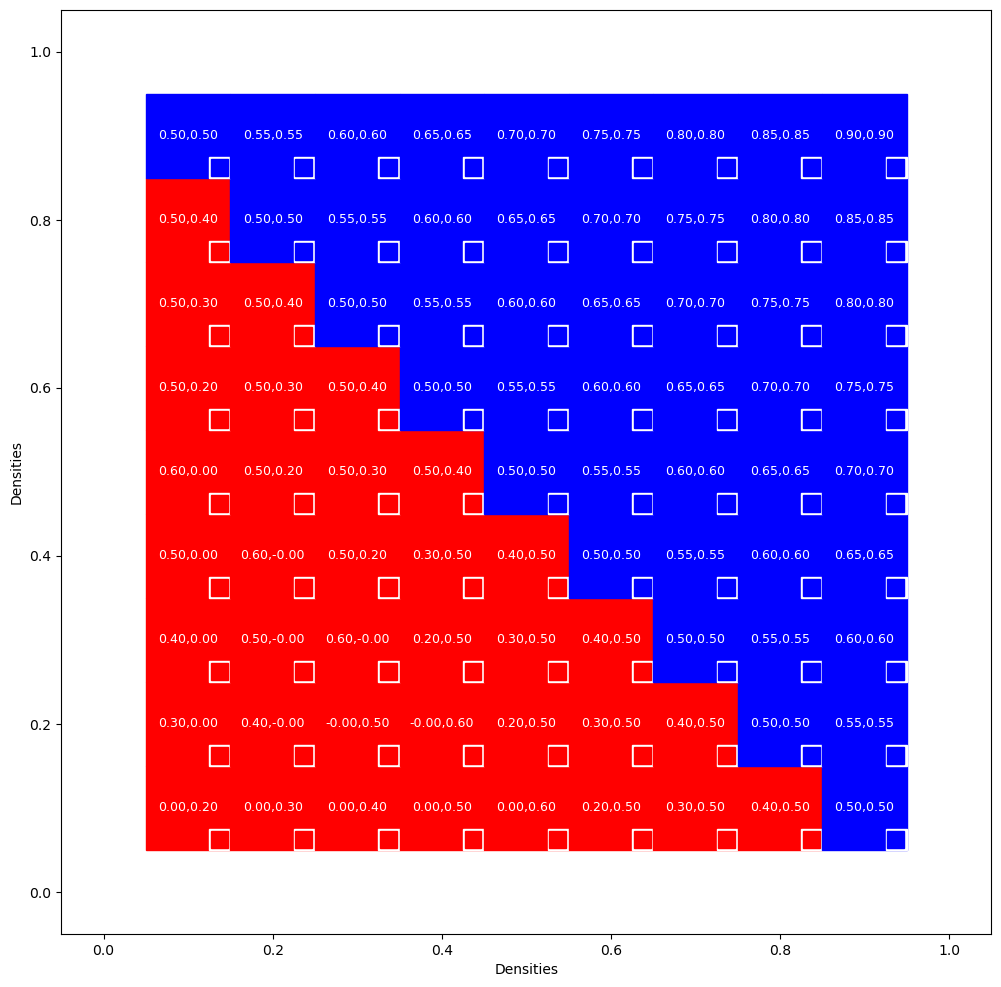

In [205]:
x = np.array(densities)
y = np.array(densities)

# create grid in coordinates x, y
X, Y = np.meshgrid(x, y)

# create figure
fig, ax = plt.subplots(figsize=(12, 12))

for i in range(len(densities)):
    for j in range(len(densities)):
        text = "%.2f,%.2f" % (results[i,j,0] , results[i,j,1])
        if (np.min(results[i,j])/np.max(results[i,j])) <= 0.9:
            color = "red"
        else:
            color = "blue"
            
        square_size = 0.1
        cell = plt.Rectangle((X[i][j] - 0.05, Y[i][j] - 0.05), square_size, square_size, fill=True, color= color)
        ax.add_patch(cell)
        
        detail_square_size = 0.025
        cell_small = plt.Rectangle((X[i][j] + square_size/2 - detail_square_size, Y[i][j] - square_size/2), detail_square_size, detail_square_size, fill=True, color= 'white')
        ax.add_patch(cell_small)
        
        # teoretical result
        density_T = (densities[i] + densities[j])/2
        if(density_T < 0.5):
            color2 = "red"
        else:
            color2 = "blue"
            
        small_square_size = 0.02
        cell_small = plt.Rectangle((X[i][j] + square_size/2 - small_square_size - detail_square_size/8, Y[i][j] - square_size/2 + detail_square_size/10), small_square_size, small_square_size, fill=True, color= color2)
        ax.add_patch(cell_small)
        
        
        ax.text(X[i][j], Y[i][j], text, va='center', ha='center', fontsize=9, color='white')

# Labels
ax.set_xlabel('Densities')
ax.set_ylabel('Densities')

# Graph limits
ax.set_xlim(x[0] - 0.15, np.max(x) + 0.15)
ax.set_ylim(y[0] - 0.15, np.max(y) + 0.15)

plt.show()

In [199]:
pho_Ts = np.linspace(0.1,0.9,17, endpoint=True)

results = np.full((len(pho_Ts),2),[0,'a'])

for k in range(len(pho_Ts)):
    pho_T = pho_Ts[k]
    if pho_T >= 0.5:
        pho_min = 2*pho_T - 1
        pho_max = 1
    else:
        pho_min = 0
        pho_max = 2*pho_T
        
    pho_average = (pho_max + pho_min)/2

    steps = 1000
    phos = np.linspace(pho_min,pho_max,steps,endpoint=True)
    pho_array = np.zeros([steps,2])
    U = np.zeros(steps)

    maxU = 0
    i_max = 0

    for i in range(steps):
        pho = phos[i]
        pho_2 = 2 * (pho_T - pho/2)
        pho_array[i] = [pho,pho_2]
        U[i] = n*n*(pho_array[i,0]*utility_function_per_block(pho_array[i,0]) + pho_array[i,1]*utility_function_per_block(pho_array[i,1]))
        if(U[i] > maxU):
            maxU = U[i]
            i_max = i
    
    """     
    plt.figure()
    plt.plot(phos, U)
    plt.show()
    """
    
    if(abs(phos[i_max] - pho_average)/pho_average > 0.1):
        results[k] = [pho_T, 'segregated']
    else:
        results[k] = [pho_T, 'homogeneous']
    
print(results)

[['0.1' 'segregated']
 ['0.150000000' 'segregated']
 ['0.2' 'segregated']
 ['0.25' 'segregated']
 ['0.300000000' 'segregated']
 ['0.35' 'segregated']
 ['0.4' 'segregated']
 ['0.450000000' 'segregated']
 ['0.5' 'homogeneous']
 ['0.55' 'homogeneous']
 ['0.6' 'homogeneous']
 ['0.65' 'homogeneous']
 ['0.700000000' 'homogeneous']
 ['0.75' 'homogeneous']
 ['0.8' 'homogeneous']
 ['0.85' 'homogeneous']
 ['0.9' 'homogeneous']]
